In [92]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [93]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from collections import namedtuple

import seaborn as sns

In [94]:
### General Processing

In [95]:
main = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'KM Data Edits')
datapull = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'Data Pull Sheet')
aums = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'All Institution AUMs')
removed = pd.read_excel('Movant Report Analysis (01.01.2016-08.31.2019) - unlinked.xlsx', sheet_name = 'Removed cases')

In [96]:
removed_tickers = pd.read_csv("excluded.csv").Ticker

In [97]:
movant_categories = main["Movant ID"].str.split(".", n=2, expand = True)
main['Movant Group'] = movant_categories[0]+movant_categories[1]

In [98]:
main = main.merge(aums[['Institutional Movant', 'AUM']], how = 'left', left_on = 'Movant', right_on = 'Institutional Movant')

In [99]:
main = main.merge(datapull[['Ticker','Damage Bucket', "Filing Firm", "Lead Plaintiff"]], how = 'left', on = 'Ticker')

In [100]:
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("InS", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ins", "Ins")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("G-mix", "G-Mix")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("ind", "Ind")
main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"] = main["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"].str.replace("g-Ind", "G-Ind")

In [101]:
main["Small Case"] = 0
main.loc[main["Damage Bucket"].isin(["A","B"]), "Small Case"] = 1 
main.loc[main["Lead Plaintiff"].isna(),"Lead Plaintiff"] = "None"

In [102]:
def win(a, b):
    if a in b: return 1
    else: return 0

main = main.assign(win = main.apply(lambda row: win(row["Movant"], row["Lead Plaintiff"]), axis =1))

In [103]:
main["unopposed"] = 0
main.loc[main["Contested/\nUncontested"]=="Uncontested", "unopposed"] = 1

In [104]:
#main["AUM"] = main.apply(lambda x: '${:,.2f}'.format(x["AUM"]), axis = 1)
#main["Movant Loss"] = main.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)
#datapull["Total Damages"] = datapull.apply(lambda x: '${:,.2f}'.format(x["Total Damages"]), axis = 1)

### I. MOVANT ANALYSIS BY REPORTED DAMAGES BY BUCKET

#### I. A. Number of Cases by Bucket

In [105]:
data_1a = datapull['Damage Bucket'].value_counts()

In [106]:
y_val = data_1a.sort_index()
x_val = data_1a.sort_index().index

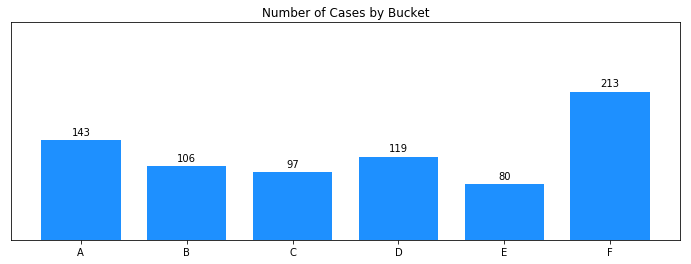

In [107]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Cases by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

ax.set_ylim([0,y_val.max()+ 100])

rects = ax.patches

ax.yaxis.set_ticks_position('none')

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### I.B. Analysis by Bucket

In [108]:
data_1b = datapull[['Damage Bucket', 'Ticker','Total Damages', '% of Total Damages']].dropna()
data_1b['Total Damages'] = pd.to_numeric(data_1b['Total Damages'], errors='coerce').fillna(0)
data_1b['% of Total Damages'] = pd.to_numeric(data_1b['% of Total Damages'], errors='coerce').fillna(0)
data_1b = data_1b[~data_1b.Ticker.isin(data_1b[(data_1b['Damage Bucket']=='F') & (data_1b['Total Damages']==0)]['Ticker'])]


In [109]:
data_1b_total = data_1b[['Damage Bucket', 'Ticker','Total Damages']]
data_1b_describe_total = data_1b_total.pivot_table(index = 'Ticker', columns = 'Damage Bucket', values = 'Total Damages')
data_1b_describe_total = data_1b_describe_total.describe()

In [110]:
data_1b_bps = data_1b[['Damage Bucket', 'Ticker','% of Total Damages']]
data_1b_describe_bps = data_1b_bps.pivot_table(index = 'Ticker', columns = 'Damage Bucket', values = '% of Total Damages')
data_1b_describe_bps = data_1b_describe_bps.describe()

In [111]:
x_val = np.sort(data_1b['Damage Bucket'].unique())

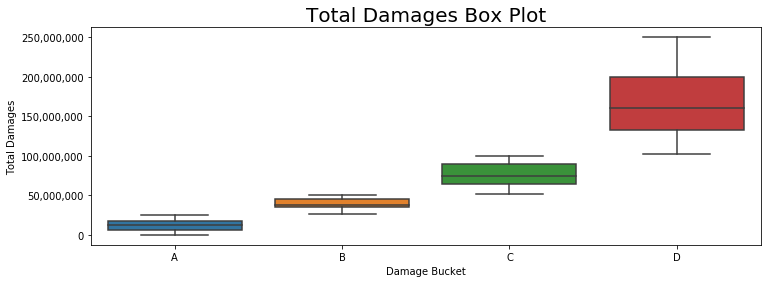

In [112]:
#### plt.clf()
pd.options.display.float_format = '${:,.0f}'.format
plt.figure(figsize=(12,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[~data_1b_total["Damage Bucket"].isin(["E", "F"])], order = x_val[:4], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

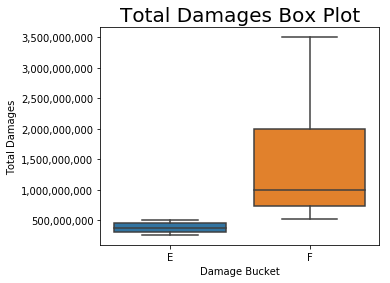

In [113]:
plt.figure(figsize=(5,4))
plt.title("Total Damages Box Plot", size = 20)
ax = sns.boxplot(y = 'Total Damages', x = 'Damage Bucket', data = data_1b_total[data_1b_total["Damage Bucket"].isin(["E", "F"])], order = x_val[4:6], showfliers=False)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))
plt.show()

In [114]:
print("By Total Damage, Does Not Include DC Damages in Bucket F")
data_1b_describe_total

By Total Damage, Does Not Include DC Damages in Bucket F


Damage Bucket,A,B,C,D,E,F
count,$143,$105,$97,$119,$79,$189
mean,"$12,352,797","$38,384,762","$76,113,402","$168,672,269","$382,202,532","$2,485,899,471"
std,"$7,291,582","$6,643,038","$14,861,777","$41,460,030","$78,746,328","$4,102,095,694"
min,$0,"$26,000,000","$52,000,000","$102,000,000","$260,000,000","$515,000,000"
25%,"$6,000,000","$35,000,000","$65,000,000","$133,000,000","$300,000,000","$740,000,000"
50%,"$12,000,000","$38,000,000","$75,000,000","$160,000,000","$365,000,000","$1,000,000,000"
75%,"$17,500,000","$45,000,000","$90,000,000","$200,000,000","$450,000,000","$2,000,000,000"
max,"$25,000,000","$50,000,000","$100,000,000","$250,000,000","$500,000,000","$25,000,000,000"


In [115]:
pd.options.display.float_format = '{:,.2%}'.format
print("By BPS, Does Not Include DC Damages in Bucket F")
data_1b_describe_bps 

By BPS, Does Not Include DC Damages in Bucket F


Damage Bucket,A,B,C,D,E,F
count,"14,300.00%","10,500.00%","9,700.00%","11,900.00%","7,900.00%","18,900.00%"
mean,2.67%,1.11%,0.49%,0.61%,0.36%,0.36%
std,5.85%,2.00%,1.02%,1.64%,0.76%,0.88%
min,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
25%,0.08%,0.06%,0.02%,0.04%,0.01%,0.01%
50%,0.51%,0.33%,0.12%,0.16%,0.07%,0.09%
75%,2.01%,1.21%,0.46%,0.40%,0.33%,0.28%
max,38.40%,13.61%,6.80%,12.57%,4.90%,7.29%


#### Largest and 2nd Largest Bucket

In [116]:
for i in x_val:
    data_1b_largest = np.sort(main[(main["Damage Bucket"] == i) & (~main["Ticker"].isin(removed_tickers))].pivot_table(index = "Movant ID", columns = "Ticker", values = "Total Damages in Group").fillna(0), axis = 0)[-2:,:]
    if i == "A":
        data_1b_largest1 = pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[1]).describe()
        data_1b_largest2 = pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[0]).describe()
    else:
        data_1b_largest1 = pd.concat([data_1b_largest1, pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[1]).describe()], axis = 1)       
        data_1b_largest2 = pd.concat([data_1b_largest2, pd.DataFrame(np.transpose(np.transpose(data_1b_largest)[np.all(data_1b_largest != 0, axis =0)])[0]).describe()], axis = 1)

In [117]:
data_1b_largest1.columns = x_val.tolist()
data_1b_largest2.columns = x_val.tolist()

In [118]:
pd.options.display.float_format = '${:,.0f}'.format
print("Largest Movants")
data_1b_largest1

Largest Movants


,A,B,C,D,E,F
count,$85,$64,$53,$81,$47,$160
mean,"$134,386","$315,645","$195,321","$578,772","$666,692","$4,262,018"
std,"$184,353","$345,440","$193,500","$819,961","$706,465","$8,177,377"
min,"$1,667",$225,"$6,105",$76,"$2,083","$2,419"
25%,"$27,284","$69,514","$49,334","$132,019","$113,892","$393,574"
50%,"$72,994","$177,874","$120,984","$431,941","$314,789","$1,621,409"
75%,"$144,271","$457,163","$283,547","$695,596","$1,118,261","$4,537,218"
max,"$1,073,468","$1,324,688","$773,028","$6,373,736","$2,467,510","$68,161,973"


In [119]:
pd.options.display.float_format = '${:,.0f}'.format
print("Second Largest Movants")
data_1b_largest2

Second Largest Movants


,A,B,C,D,E,F
count,$85,$64,$53,$81,$47,$160
mean,"$46,953","$105,817","$59,265","$228,608","$247,507","$1,519,852"
std,"$74,364","$156,047","$59,842","$467,297","$284,396","$3,741,251"
min,$73,$215,"$1,559",$51,$479,$33
25%,"$4,878","$19,899","$11,800","$39,750","$25,704","$115,706"
50%,"$14,897","$44,022","$38,421","$143,026","$141,390","$481,833"
75%,"$51,426","$127,147","$83,244","$268,919","$378,293","$1,409,536"
max,"$465,143","$975,503","$289,638","$4,124,236","$1,226,503","$30,462,907"


#### I.C. Win-Loss Analysis

In [120]:
data_1c = main[["Movant", "Damage Bucket", "Type", "win", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"]]

#### I.C.1 Largest Movant

In [121]:
data_1c1_wins = main.groupby("Movant")["win"].agg(["sum", "count"])
data_1c1_wins["win_rate"] = data_1c1_wins["sum"]/data_1c1_wins["count"]
data_1c1_losses = main.groupby("Movant")["Movant Loss"].sum()

In [122]:
data_1c1_largest = data_1c1_losses[data_1c1_losses == data_1c1_losses.max()].index

In [123]:
pd.options.display.float_format = '{:,.2f}'.format
print("The number of wins, cases and win rate of the largest movant is")
data_1c1_wins[data_1c1_wins.index.isin(data_1c1_largest)]

The number of wins, cases and win rate of the largest movant is


,sum,count,win_rate
Movant,,,
Union Asset Management Holding AG,7,9,0.78


In [124]:
#### I.C.2 Win Rate by Movant Category

In [125]:
data_1c2 = data_1c.groupby("Type")["win"].agg(["sum", "count"])
data_1c2["win_rate"] = data_1c2["sum"]/data_1c2["count"]

In [126]:
x_val = data_1c2.index
y_val = data_1c2.win_rate

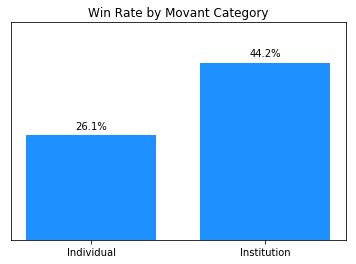

In [127]:

fig, ax = plt.subplots(figsize=(6,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Movant Category')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

In [128]:
#### I.C.3. Win Rate By Bucket

In [129]:
data_1c3 = data_1c.groupby("Damage Bucket")["win"].agg(["sum", "count"])
data_1c3["win_rate"] = data_1c3["sum"]/data_1c3["count"]

In [130]:
x_val = data_1c3.index
y_val = data_1c3.win_rate

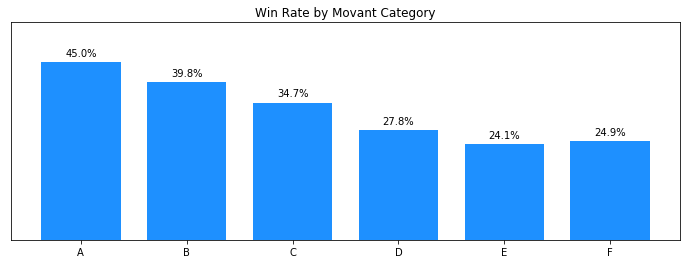

In [131]:

fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Win Rate by Movant Category')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 0.1])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, "{:,.1%}".format(label),
            ha='center', va='bottom')
plt.show()

In [132]:
#### I.C.4. Win Rate By Bucket by Movant Type

In [133]:
data_1c4 = data_1c.groupby(["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Damage Bucket"])["win"].agg(["sum", "count"])
data_1c4["win_rate"] = data_1c4["sum"]/data_1c4["count"]

In [134]:
x_val = data_1c4.index
y_val = data_1c4.win_rate

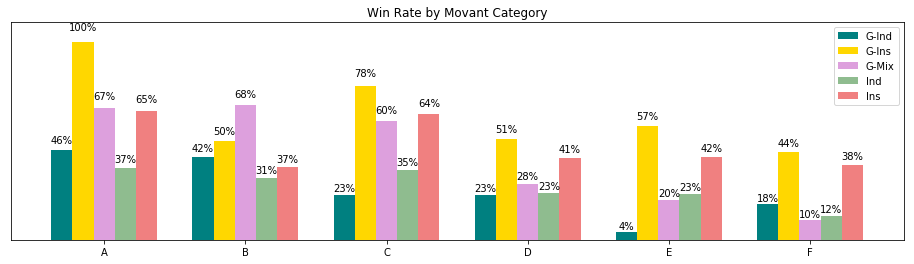

In [135]:
fig, ax = plt.subplots(figsize=(16,4))
width = 0.15
ind = np.arange(6)
legends = ["G-Ind", "G-Ins", "G-Mix", "Ind", "Ins"]
buckets = ["A", "B", "C", "D", "E", "F"]
colors=['teal', 'gold', 'plum', 'darkseagreen', 'lightcoral', "mediumorchid"]

plt.title('Win Rate by Movant Category')
plt.yticks([], [])

rects = []

for i in range(len(legends)):
    box = ax.bar(ind + width*(i-1), y_val[legends[i]], width, color = colors[i], label = legends[i])
    rects.append(box)

plt.legend([i for i in rects], legends)


ax.set_xticks(ind+width)
ax.set_xticklabels(buckets)
ax.yaxis.set_ticks_position('none')
ax.set_ylim([0,y_val.max()+ 0.1])

def autolabel(i):
    for rect in i:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, "{:,.0%}".format(h),
                ha='center', va='bottom')
        
for i in rects:
    autolabel(i)



plt.show()

### II. ANALYSIS BY TYPE OF MOVANT

#### II. A. Number of Movants by Bucket

In [136]:
data_2a = main["Damage Bucket"].value_counts()

In [137]:
y_val = data_2a.sort_index()
x_val = data_2a.sort_index().index

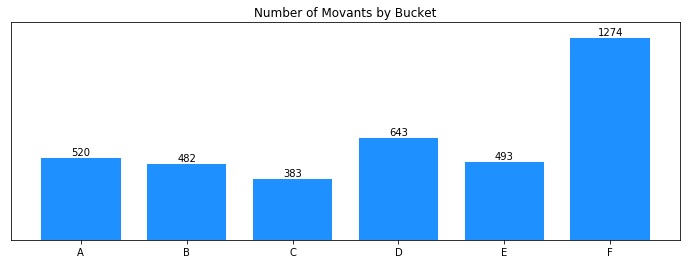

In [138]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### II.B. Number of Movants by Case

In [139]:
data_2b = main.groupby("Ticker")["Movant ID"].count().reset_index()
data_2b_describe = data_2b.describe()

In [140]:
pd.options.display.float_format = '{:.2f}'.format
data_2b_describe

,Movant ID
count,708.00
mean,5.36
std,4.66
min,1.00
25%,2.00
50%,4.00
75%,7.00
max,44.00


#### II.C. Movant By Type By Bucket

In [141]:
data_2c = main[["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant ID"]]

In [142]:
data_2c_grouped = data_2c.groupby(["Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"])["Movant ID"].count().reset_index()

In [143]:
data_2c_grouped

,Damage Bucket,"Type (Ind, Ins, G-Ind, G-Ins, G-Mix)",Movant ID
0,A,G-Ind,279
1,A,G-Ins,8
2,A,G-Mix,21
3,A,Ind,186
4,A,Ins,26
5,B,G-Ind,271
6,B,G-Ins,12
7,B,G-Mix,25
8,B,Ind,144
9,B,Ins,30


#### II.D. For Groups

In [144]:
data_2d = main[["Movant Group", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Movant Loss", "Movant ID", "win"]]
data_2d_groupcount = data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant ID"].nunique()/data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Group"].nunique()
data_2d_groupcount = data_2d_groupcount.append(pd.Series(data_2d["Movant ID"].nunique()/data_2d["Movant Group"].nunique(), index = ["Total"]))
data_2d_loss = data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["Movant Loss"].mean()
data_2d_loss = data_2d_loss.append(pd.Series(main["Movant Loss"].mean(), index = ["Total"]))
data_2d_winrate = data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].sum()/data_2d.groupby("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")["win"].count()
data_2d_winrate = data_2d_winrate.append(pd.Series(main["win"].sum()/main["win"].count(), index = ["Total"]))

In [145]:
data_2d = pd.concat([data_2d_groupcount, data_2d_loss, data_2d_winrate], axis = 1)
data_2d.columns = ["Avg # of Members for Each Type", "Avg Losses", "Win Rate"]
data_2d["Avg Losses"] = data_2d.apply(lambda x: '${:,.2f}'.format(x["Avg Losses"]), axis = 1)
data_2d["Win Rate"] = data_2d.apply(lambda x: "{:,.1%}".format(x["Win Rate"]), axis = 1)

In [146]:
print("Statistics by Type")
pd.options.display.float_format = '{:,.2f}'.format
data_2d

Statistics by Type


,Avg # of Members for Each Type,Avg Losses,Win Rate
G-Ind,2.88,"$149,941.97",27.0%
G-Ins,2.51,"$1,903,828.65",50.1%
G-Mix,2.91,"$834,533.03",31.4%
Ind,1.05,"$302,787.63",24.9%
Ins,1.03,"$2,395,033.35",41.6%
Total,1.63,"$724,889.37",30.9%


#### II.E. For Unopposed Lead Plaintiff Motions

In [147]:
data_2e = main[main["unopposed"]==1][["Damage Bucket","Movant","Movant Loss"]]

#### III.E.1. Number of Unopposed by Bucket

In [148]:
data_2e1 = data_2e.groupby("Damage Bucket")["Movant"].count().reset_index()

In [149]:
data_2e1

,Damage Bucket,Movant
0,A,65
1,B,39
2,C,39
3,D,25
4,E,19
5,F,46


#### II.E.2 Average Loss of Unopposed by Bucket

In [150]:
data_2e2 = data_2e.groupby("Damage Bucket")["Movant Loss"].mean().reset_index()
data_2e2["Movant Loss"] = data_2e2.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)


In [151]:
pd.options.display.float_format = '${:,.2}'.format
data_2e2

,Damage Bucket,Movant Loss
0,A,"$41,078.34"
1,B,"$52,554.38"
2,C,"$76,122.45"
3,D,"$112,224.33"
4,E,"$220,700.18"
5,F,"$1,817,064.62"


#### II.F. Fight Analysis

In [152]:
data_2f = main[["Small Case", "Type", "win"]]

In [153]:
data2f_wins = data_2f.groupby(["Small Case", "Type"])["win"].agg(["sum", "count"])
data2f_wins["win_rate"] = data2f_wins["sum"]/  data2f_wins["count"]

In [154]:
pd.options.display.float_format = '{:.1%}'.format
data2f_wins["win_rate"].reset_index()

,Small Case,Type,win_rate
0,0,Individual,19.2%
1,0,Institution,42.4%
2,1,Individual,40.6%
3,1,Institution,60.8%


### III. ANALYSIS BY INSTITUTIONAL MOVEMENT TYPE

#### III. A. Institutional Movants by Bucket

In [155]:
data_3 = main[main["Type"]== "Institution"]

In [156]:
data_3a = data_3.groupby('Damage Bucket')['Institutional Movant'].count()

In [157]:
y_val = data_3a.sort_index()
x_val = data_3a.sort_index().index

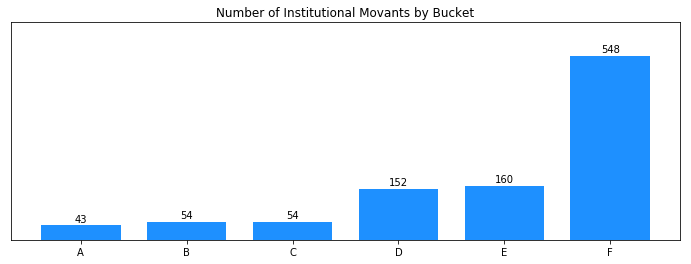

In [158]:
fig, ax = plt.subplots(figsize=(12,4))
width = 0.75
ind = np.arange(len((y_val)))
plt.title('Number of Institutional Movants by Bucket')
plt.yticks([], [])
ax.bar(x_val, y_val, width, color = "dodgerblue")

rects = ax.patches

ax.yaxis.set_ticks_position('none')

ax.set_ylim([0,y_val.max()+ 100])

for rect, label in zip(rects, y_val):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')
plt.show()

#### III.B Average Loss By Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [159]:
data_3b = data_3[['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3b_describe = data_3b.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3b_describe = data_3b_describe.describe()

In [160]:
pd.options.display.float_format = '{:.0f}'.format
data_3b_describe

Damage Bucket,A,B,C,D,E,F
count,43,54,54,151,154,537
mean,429204,1277577,395644,709876,990476,3173825
std,1184618,6281794,808751,1723696,2583531,7654072
min,875,5401,1050,112,1609,924
25%,57340,89299,46455,97645,115171,245303
50%,153220,152860,135858,248948,282278,677651
75%,377444,588367,391554,512536,832294,2202906
max,7793640,46378080,4725022,13674214,23517243,87214281


#### III.C. Average Loss By Winning Institutional Movant by Bucket
#### Note: Does not include institutional movants without losses (N/A)

In [161]:
data_3c = data_3[data_3.win==1][['Damage Bucket',  "Type", 'Movant Loss']].dropna()
data_3c_describe = data_3c.pivot(columns = 'Damage Bucket', values = 'Movant Loss')
data_3c_describe = data_3c_describe.describe()

In [162]:
data_3c_describe

Damage Bucket,A,B,C,D,E,F
count,32,27,35,64,74,208
mean,516957,483075,502777,1191733,1380941,4449465
std,1361965,749487,966995,2487095,3336746,10029567
min,11534,5401,1050,500,32033,1130
25%,78644,80829,93742,184464,162269,302689
50%,170972,152456,193034,336260,318825,1017720
75%,381650,630205,430921,940687,1096521,3670842
max,7793640,2813256,4725022,13674214,23517243,87214281


#### III.D. Average AUM of Institutional Movant by Bucket
##### Note: Count Includes Only Institutional Movants with AUMs (no N/As)

In [163]:
data_3d = main[['Damage Bucket',  "Institutional Movant", "AUM"]].dropna()
data_3d_describe = data_3d.pivot(columns = 'Damage Bucket', values = 'AUM')
data_3d_describe = data_3d_describe.describe()

In [164]:
pd.options.display.float_format = '${:,.0f}'.format
data_3d_describe

Damage Bucket,A,B,C,D,E,F
count,$21,$38,$31,$122,$131,$459
mean,"$1,969,655,421","$4,728,281,438","$10,643,801,744","$3,719,245,440","$10,333,996,020","$33,664,841,062"
std,"$3,541,343,579","$12,440,933,508","$43,506,842,521","$12,973,549,765","$34,183,727,482","$110,883,680,055"
min,"$8,570,653","$8,000,000","$6,700,000","$486,578","$2,991,784","$1,001,358"
25%,"$139,810,268","$332,814,800","$205,139,094","$365,441,086","$373,845,000","$553,586,924"
50%,"$819,290,000","$743,223,332","$683,136,187","$953,880,151","$1,046,472,269","$2,228,409,958"
75%,"$1,936,000,000","$2,285,139,160","$1,960,333,082","$2,203,819,861","$2,838,232,978","$13,000,000,000"
max,"$14,406,000,000","$71,360,000,000","$242,262,242,175","$135,270,275,000","$242,262,242,175","$1,515,000,000,000"


#### III.E. Frequent Flyer Analysis

#### III.E.1. Movant Type

In [165]:
data_3e = main[["Institutional Movant", "Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", 'Investor Frequent Flyer', 'Movant Loss', "Filing Firm"]]
data_3e = data_3e[~data_3e["Institutional Movant"].isna()]
data_3e.loc[(data_3e["Investor Frequent Flyer"].isna()),"Investor Frequent Flyer"] = "NotFF"

In [166]:
data_3e1 = data_3e.groupby(["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Type (Ind, Ins, G-Ind, G-Ins, G-Mix)")

In [167]:
y_val1 = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Institutional Movant"]
y_val2 = data_3e1[data_3e1["Investor Frequent Flyer"]== "NotFF"]["Institutional Movant"]
x_val = data_3e1[data_3e1["Investor Frequent Flyer"]== "FF"]["Type (Ind, Ins, G-Ind, G-Ins, G-Mix)"]

In [168]:
data_3e1

,"Type (Ind, Ins, G-Ind, G-Ins, G-Mix)",Investor Frequent Flyer,Institutional Movant
0,G-Ind,NotFF,2
1,G-Ins,FF,227
2,G-Ins,NotFF,131
3,G-Mix,FF,21
4,G-Mix,NotFF,70
5,Ind,FF,5
6,Ins,FF,374
7,Ins,NotFF,181


#### III.E.2.By Bucket

In [169]:
data_3e2 = data_3e.groupby(["Damage Bucket", "Investor Frequent Flyer"])["Institutional Movant"].count().reset_index().sort_values("Damage Bucket")

In [170]:
data_3e2

,Damage Bucket,Investor Frequent Flyer,Institutional Movant
0,A,FF,21
1,A,NotFF,22
2,B,FF,27
3,B,NotFF,27
4,C,FF,24
5,C,NotFF,30
6,D,FF,95
7,D,NotFF,57
8,E,FF,100
9,E,NotFF,60


#### III.E.3.By Filing Firm

#### See attached csv

In [171]:
#data_3e3 = main[["Movant", "Institutional Movant", "Company Name","Damage Bucket", "Type (Ind, Ins, G-Ind, G-Ins, G-Mix)", "Type", 'Investor Frequent Flyer', 'Movant Loss', "Firm Names - Movant", "AUM"]]
#data_3e3.loc[(data_3e3["Investor Frequent Flyer"].isna()) & (data_3e3["Type"]=="Institution"),"Investor Frequent Flyer"] = "NotFF"

In [172]:
#data_3e3_count = data_3e3.groupby("Movant")["Type"].count().reset_index().rename(columns = {"Type": "case_count"})

In [173]:
#data_3e3 = data_3e3.merge(data_3e3_count, how = "left", on = "Movant")

In [174]:
#data_3e3_repeat = data_3e3[data_3e3.case_count > 1].sort_values(["Type","Movant", "Firm Names - Movant"])
#data_3e3_repeat["Movant Loss"] = data_3e3_repeat.apply(lambda x: '${:,.2f}'.format(x["Movant Loss"]), axis = 1)
#data_3e3_repeat["AUM"] = data_3e3_repeat.apply(lambda x: '${:,.2f}'.format(x["AUM"]), axis = 1)

In [175]:
#data_3e3_repeat_ind = data_3e3_repeat[data_3e3_repeat.Type == "Individual"][["Movant","Firm Names - Movant", "Company Name", "Movant Loss"]]
#data_3e3_repeat_ins = data_3e3_repeat[data_3e3_repeat.Type == "Institution"][["Movant","AUM","Firm Names - Movant", "Company Name", "Movant Loss"]]

In [91]:
#with pd.ExcelWriter('FrequentFlyerAnalysis_201911.xlsx') as writer:  # doctest: +SKIP
#    data_3e3_repeat_ind.to_excel(writer, sheet_name='Individual', index = False)
#    data_3e3_repeat_ins.to_excel(writer, sheet_name='Institution', index = False)